## 12mo Desafío: `Daruich`, Nicolas Alberto
----

# Librerias

In [1]:
import re
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats
from sklearn.impute import SimpleImputer

----
# Data Wrangling 

----
### Funciones

In [2]:
# Funcion: Structural Information
def structural_information(dataframe):

    ''' Indica la cantidad de filas, columnas y valores nulos. A estos ultimos ademas
    los agrupa segun la columna del que forman parte, y el porcentaje que representan del total.
    Tambien informa sobre la presencia de filas duplicadas.
    
    Parameters:
    - dataframe: DataFrame que se va a analizar. '''
    
    # Calcula la cantidad de valores nulos por columna
    dataframe_na = dataframe.isna().sum()
    
    # Calcula la cantidad total de valores nulos en el DataFrame
    na_values = dataframe_na.sum()
    
    # Obtiene el número de filas y columnas del DataFrame
    rows, columns = dataframe.shape

    # Contar el número de filas con algún valor nulo
    rows_with_na = dataframe.isnull().any(axis=1).sum()

    # Obtiene el numero de filas duplicadas
    dataframe_duplicated = dataframe.duplicated().sum()
    
    # Imprime el análisis general de la estrucdutura del DataFrame
    print("Analisis Rapido de la Estructura del DF")
    print(f"\nFilas: {rows}. Columnas: {columns}.")
    print(f"\nValores Nulos: {na_values} / {rows * columns} ({na_values / (rows * columns):.3f}).")
    
    # Imprime la cantidad de valores nulos, el porcentaje respecto al total de filas, y agrupa los según la columna perteneciente
    for attribute, n in dataframe_na.items():
        if n > 0: print(f"  - {attribute.upper()}: {n} ({(n / rows):.3f}).")

    print(f" Filas con algun (any) dato nulo: {rows_with_na} ({(rows_with_na / rows):.2f})")
    print(f"\nValores Duplicados: {dataframe_duplicated}")

In [3]:
# Funcion: Codification
def codification(dataframe, column):

    ''' Esta función realiza la codificación de una columna categórica en un DataFrame.

    Parameters:
    - dataframe: DataFrame que contiene la columna a codificar.
    - column: Nombre de la columna que se va a codificar.

    Output:
    - ref_table: Diccionario que contiene la relación entre los valores originales y sus códigos.
    - dataframe[column]: Serie de la columna codificada en el DataFrame original. '''
    
    # Obtiene los valores únicos de la columna, excluyendo los valores nulos
    labels = dataframe[column].dropna().unique()

    # Crea un diccionario de codificación, asignando un código único a cada valor único
    coding = {label: code for code, label in enumerate(labels)}

    # Aplica la codificación a la columna del DataFrame
    dataframe[column] = dataframe[column].apply(lambda row: str(coding[row]) if pd.notna(row) else row)

    # Crea una tabla de referencia que relaciona los códigos y los valores originales
    ref_table = {f'{column}': [value for value in coding.values()], f'{column}_label': [key for key in coding.keys()]}

    # Devuelve la tabla de referencia y la columna codificada del DataFrame original
    return ref_table, dataframe[column]

In [4]:
# Funcion: Outliers
def outliers(dataframe, columns, q1=0.25, q3=0.75):

    ''' Esta función identifica y filtra los outliers en un DataFrame basándose en los cuartiles.

    Parameters:
    - dataframe: DataFrame que se va a analizar y filtrar.
    - columns: Lista de columnas en las que se identificarán los outliers.
    - q1: Cuartil inferior para el rango intercuartílico (por defecto 0.25).
    - q3: Cuartil superior para el rango intercuartílico (por defecto 0.75).

    Output:
    - dataframe_no_outliers: DataFrame resultante después de filtrar los outliers.
    - dataframe_outliers: DataFrame que contiene solo las filas con al menos un outlier. '''
    
    # Definiendo los cuartiles
    q1 = dataframe[columns].quantile(q1)
    q3 = dataframe[columns].quantile(q3)
    iqr = q3 - q1

    # Creando una mascara para outliers
    mask_outliers = ((dataframe[columns] < (q1 - 1.5 * iqr)) | (dataframe[columns] > (q3 + 1.5 * iqr)))

    # Reconociendo filas que tengan al menos un (any) outlier
    mask_outliers = mask_outliers.any(axis=1)

    # Filtrando outliers
    return dataframe[~mask_outliers], dataframe[mask_outliers]

In [5]:
# Funcion: Custom Describe
def custom_describe(dataframe, attributes):

    '''
    Esta función proporciona estadísticas descriptivas personalizadas para un conjunto específico de atributos en un DataFrame.

    Parameters:
    - dataframe: DataFrame para el cual se calcularán las estadísticas descriptivas.
    - attributes: Lista de atributos (columnas) para los cuales se calcularán las estadísticas.

    Output:
    - DataFrame con estadísticas descriptivas para los atributos seleccionados, redondeadas a dos decimales.

    '''

    return dataframe.describe().loc[attributes].round(2)

----
### Parte 1: Carga, lectura y analisis rapido de la estructura

In [6]:
# Creando el DF principal
df_main = pd.read_csv('metabolicSyndrome.csv')

----

In [7]:
# Informacion estructural
structural_information(df_main)

Analisis Rapido de la Estructura del DF

Filas: 2401. Columnas: 15.

Valores Nulos: 436 / 36015 (0.012).
  - MARITAL: 208 (0.087).
  - INCOME: 117 (0.049).
  - WAISTCIRC: 85 (0.035).
  - BMI: 26 (0.011).
 Filas con algun (any) dato nulo: 392 (0.16)

Valores Duplicados: 0


In [8]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 281.5+ KB


In [9]:
# Copiando el dataframe original
raw_df = df_main.copy()

# Vista previa (Primeras filas)
df_main.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


La columna "seqn" indica el codigo asignado por la entidad que recogio la informacion a cada observacion. Dado que es irrelevante, se procedera a eliminarla.

In [10]:
# Eliminando las columna 'seqn': 
df_main.drop(labels='seqn', axis='columns', inplace=True)

# Agregando un indice sencillo
df_main.reset_index(inplace=True)
df_main['index'] = df_main['index'].astype(int)

----

### Parte 2: Describiendo, adecuando y codificando las variables de interes
- `Age` (Edad): Variable numérica que representa la edad de los individuos en el estudio.
- `Sex` (Sexo): Variable categórica que indica el género del individuo (por ejemplo, masculino o femenino).
- `Marital` (Estado Civil): Variable categórica que describe el estado civil de los participantes (soltero, casado, divorciado, etc.).
- `Income` (Ingresos): Variable numérica que representa el nivel de ingresos de los participantes.
- `Race` (Etnia): Variable categórica que indica la etnia de los participantes.
- `WaistCirc` (Circunferencia de la Cintura): Variable numérica que mide la circunferencia de la cintura.
- `BMI` (Índice de Masa Corporal): Variable numérica que calcula el índice de masa corporal.
- `Albuminuria` (Albuminuria): Variable que indica la presencia de proteínas en la orina, lo cual puede ser un marcador de daño renal.
- `UricAcid` (Ácido Úrico): Variable numérica que indica los niveles de ácido úrico en la sangre. Altos niveles pueden estar asociados con ciertos riesgos metabólicos.
- `BloodGlucose` (Glucosa en Sangre): Variable numérica que representa los niveles de glucosa en la sangre.
- `HDL` (Colesterol de Alta Densidad): Variable numérica que indica los niveles de colesterol HDL, también conocido como "colesterol bueno".
- `Triglycerides` (Triglicéridos): Variable numérica que indica los niveles de triglicéridos en la sangre, un factor de riesgo cardiovascular.
- `MetabolicSyndrome` (Síndrome Metabólico): Variable binaria que indica la presencia o ausencia del síndrome metabólico. Es la variable objetivo para la predicción en tu modelo.

In [11]:
# Adecuando el nombre de las columnas
df_main.columns = "index edad sexo civil ingresos raza abdomen imc albuminuria albumina_creatinina uricemia glucemia hdl trigliceridemia metabolico".split()

In [12]:
# Codificando las dimensiones cualitativas y creando las tablas de referencia correspondientes
ref_tables = dict()
for column in ['sexo', 'civil', 'raza']:
    
    ref_table, codificated_df = codification(df_main, column)
    
    # Ejecutando el proceso de codificacion
    df_main[column] = codificated_df

    # Creando la tabla de referencia especifica y guardandola en 'ref_tables'
    dataframe = pd.DataFrame(ref_table)
    dataframe.set_index(dataframe.columns[0], inplace=True)
    
    current_table = {column: dataframe}
    ref_tables.update(current_table)

In [13]:
# Tabla de Referencia: Civil
ref_tables['civil']

,civil_label
civil,
0,Single
1,Married
2,Widowed
3,Divorced
4,Separated


In [14]:
# Tabla de Referencia: Raza
ref_tables['raza']

,raza_label
raza,
0,White
1,Asian
2,Black
3,MexAmerican
4,Hispanic
5,Other


In [15]:
# Tabla de Referencia: Sexo
ref_tables['sexo']

,sexo_label
sexo,
0,Male
1,Female


----
### Parte 3: Tratamiento de valores Extremos (Outliers)

In [16]:
# Estado del DataFrame: Antes de eliminar outliers
custom_describe(df_main.iloc[:, 1:], ['count', 'mean', '50%', 'std'])

,edad,ingresos,abdomen,imc,albuminuria,albumina_creatinina,uricemia,glucemia,hdl,trigliceridemia,metabolico
count,2401.00,2284.00,2316.00,2375.00,2401.00,2401.00,2401.00,2401.00,2401.00,2401.00,2401.00
mean,48.69,4005.25,98.31,28.70,0.15,43.63,5.49,108.25,53.37,128.13,0.34
50%,48.00,2500.00,97.00,27.70,0.00,7.07,5.40,99.00,51.00,103.00,0.00
std,17.63,2954.03,16.25,6.66,0.42,258.27,1.44,34.82,15.19,95.32,0.47


In [17]:
# Evaluando outliers
df_main, outliers_df = outliers(df_main, ["abdomen", "imc", "albumina_creatinina", "uricemia", "glucemia", "hdl", "trigliceridemia"])

In [18]:
# Estado del DataFrame: Despues de eliminar outliers
custom_describe(df_main, ['count', 'mean', '50%', 'std'])

,index,edad,ingresos,abdomen,imc,albuminuria,albumina_creatinina,uricemia,glucemia,hdl,trigliceridemia,metabolico
count,1726.00,1726.00,1647.00,1681.00,1711.00,1726.0,1726.00,1726.00,1726.00,1726.00,1726.00,1726.00
mean,1207.06,46.25,4198.06,95.47,27.65,0.0,7.68,5.30,98.58,54.10,105.91,0.24
50%,1209.50,45.00,3500.00,95.10,27.10,0.0,6.00,5.20,97.00,52.00,95.00,0.00
std,691.50,17.09,2989.05,13.87,5.38,0.0,5.24,1.32,11.27,12.84,46.93,0.43


In [19]:
# Valores unicos para "Albuminuria"
df_main['albuminuria'].unique()

array([0], dtype=int64)

Con la remocion de valores extremos, la columna *albuminuria* solo muestra 0 (negativo) en cada fila. Esto se debe a que columna *albumina_creatina* ya no contiene valores que determinen una albuminuria positiva. Por lo tanto, la columna en cuestion sera removida (no aporta informacion).

In [20]:
# Eliminando la columna "Albuminuria"
df_main.drop("albuminuria", axis=1, inplace=True)

----
### Parte 4: Resolviendo los datos faltantes

In [21]:
# Analisis Estructural: Previo
structural_information(df_main)

Analisis Rapido de la Estructura del DF

Filas: 1726. Columnas: 14.

Valores Nulos: 293 / 24164 (0.012).
  - CIVIL: 154 (0.089).
  - INGRESOS: 79 (0.046).
  - ABDOMEN: 45 (0.026).
  - IMC: 15 (0.009).
 Filas con algun (any) dato nulo: 262 (0.15)

Valores Duplicados: 0


Si bien los datos nulos representan una parte insignificante del DF (~ 1%), remover las filas de la cual forman parte no: esto implicaria una perdida del ~ 15%. Por lo tanto se resolveran los mismos mediante imputacion.

In [22]:
# TODO Quedo a la espera del avance del curso para conocer las formas de reconocer patrones de datos faltantes.

In [23]:
# Creando el objeto de imputacion: en este caso, la imputacion estara basada en el promedio
imputer = SimpleImputer(strategy='mean')

# Ajustar el imputador a los datos
df_main = pd.DataFrame(imputer.fit_transform(df_main), columns=df_main.columns)

In [24]:
# Analisis Estructural: Posterior
structural_information(df_main)

Analisis Rapido de la Estructura del DF

Filas: 1726. Columnas: 14.

Valores Nulos: 0 / 24164 (0.000).
 Filas con algun (any) dato nulo: 0 (0.00)

Valores Duplicados: 0


----
### Parte 5: Creando dimensiones categoricas

Se crearan dimensiones cualitativas para probar si el modelo responde mejor a estas, a las correspondientes cuantitativas o a una mezcla de ambas. Los criterios para determinarlas como positivas (1) se comenta en el siguiente bloque:

In [25]:
# Definiendo funciones diagnosticas
def peso(imc_value):
    
    ''' Basado en el indice de masa corporal (peso/altura^2):
    IMC > 35.0 -> Obesidad Morbida = 4
    IMC > 30.0 -> Obesidad = 3
    IMC > 25.0 -> Sobrepeso = 2
    IMC > 18.5 -> Normal = 1
    IMC < 18.5 -> Bajo Peso = 0 '''
    
    return 4 if imc_value > 35 else (3 if imc_value > 30 else (2 if imc_value > 25 else (1 if imc_value > 18.5 else 0)))

def circunferencia(sexo, abdomen):
    
    ''' Basado en los criterios ATP III (2003)*:
    Perímetro abdominal > 102 cm en Hombres; > 88 cm en Mujeres '''
    
    sexo = int(sexo)
    return 1 if ((sexo == 0) and (abdomen > 88)) or ((sexo == 1) and (abdomen > 102)) else 0

def hiperuricemia(sexo, uricemia):

    ''' Farreraz-Rosman Medicina Interna 19° Edicíon
    Uricemia > 7 mg/dL en Hombres; > 6 mg/dL en Mujeres '''
    
    sexo = int(sexo)
    return 1 if ((sexo == 0) and (uricemia > 6)) or ((sexo == 1) and (uricemia > 7)) else 0

def hiperglucemia(glucemia):

    ''' Basado en los criterios ATP III (2003)*:
    Glucemia basal ≥ 100 mg/dL (5,6 mmol/L) '''

    return 1 if glucemia > 100 else 0

def dislipidemia(sexo, hdl):

    ''' Basado en los criterios ATP III (2003)*:
    HDL-c < 40 mg/dL en Hombres; < 50 mg/dL en Mujeres '''

    sexo = int(sexo)
    return 1 if ((sexo == 0) and (hdl < 50)) or ((sexo == 1) and (hdl < 40)) else 0

def hipertrigliceridemia(trigliceridemia):
    
    ''' Basado en los criterios ATP III (2003)*:
    Trigliceridemia ≥ 150 mg/dL '''
        
    return 1 if trigliceridemia > 150 else 0

In [26]:
# Creando la Tabla Categorica
df_categorical = pd.DataFrame()

# Creando la columna Peso
df_categorical['peso'] = df_main['imc'].apply(peso)

# Creando la columna Circunferencia
df_categorical['circunferencia'] = df_main.apply(lambda row: circunferencia(row['sexo'], row['abdomen']), axis=1)

# Creando la columna Circunferencia
df_categorical['hiperuricemia'] = df_main.apply(lambda row: hiperuricemia(row['sexo'], row['uricemia']), axis=1)

# Creando la columna Hiperglucemia
df_categorical['hiperglucemia'] = df_main['glucemia'].apply(hiperglucemia)

# Creando la columna Dislipidemia
df_categorical['dislipidemia'] = df_main.apply(lambda row: hiperuricemia(row['sexo'], row['hdl']), axis=1)

# Creando la columna Hipertrigliceridemia
df_categorical['hipertrigliceridemia'] = df_main['trigliceridemia'].apply(hiperglucemia)

# Agregando un indice
df_categorical.reset_index(inplace=True)
df_categorical['index'] = df_categorical['index'].astype(int)

In [27]:
# Presentando la tabla categorica
df_categorical.head()

,index,peso,circunferencia,hiperuricemia,hiperglucemia,dislipidemia,hipertrigliceridemia
0,0,1,0,0,0,1,0
1,1,1,0,0,0,1,0
2,2,1,0,0,1,1,0
3,3,3,1,0,1,1,1
4,4,1,0,0,0,1,1


----
### Parte 6: Adecuando el tipo de datos

In [28]:
# Adecuando el tipo de datos
def data_transformation(dataframe, columns, type):
    for column in columns:
        dataframe[column] = dataframe[column].astype(type)

# df_categorical -> ALL CATEGORY
data_transformation(df_categorical, df_categorical.columns, 'category')

# df_main -> SOME INT (Para evitar que despues se guarden como categorias en formato flotante)
data_transformation(df_main, ['edad', 'sexo', 'civil', 'raza', 'metabolico'], 'int')

# df_main -> SOME CATEGORY
data_transformation(df_main, ['sexo', 'civil', 'raza', 'metabolico'], 'category')

In [29]:
# df_main -> To INT
df_main['index'] = df_main['index'].astype(int)
df_main['ingresos'] = df_main['ingresos'].astype(int)

----
----
## Conclusion

In [30]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726 entries, 0 to 1725
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   index                1726 non-null   int32   
 1   edad                 1726 non-null   int32   
 2   sexo                 1726 non-null   category
 3   civil                1726 non-null   category
 4   ingresos             1726 non-null   int32   
 5   raza                 1726 non-null   category
 6   abdomen              1726 non-null   float64 
 7   imc                  1726 non-null   float64 
 8   albumina_creatinina  1726 non-null   float64 
 9   uricemia             1726 non-null   float64 
 10  glucemia             1726 non-null   float64 
 11  hdl                  1726 non-null   float64 
 12  trigliceridemia      1726 non-null   float64 
 13  metabolico           1726 non-null   category
dtypes: category(4), float64(7), int32(3)
memory usage: 122.0 KB


## Tabla Completa

In [31]:
# Finalmente
df_full = pd.merge(df_main, df_categorical, on='index')
df_full.set_index('index', inplace=True)

In [32]:
df_full.head()

,edad,sexo,civil,ingresos,raza,abdomen,imc,albumina_creatinina,uricemia,glucemia,hdl,trigliceridemia,metabolico,peso,circunferencia,hiperuricemia,hiperglucemia,dislipidemia,hipertrigliceridemia
index,,,,,,,,,,,,,,,,,,,
0,22,0,0,8200,0,81.0,23.3,3.88,4.9,92.0,41.0,84.0,0,1,0,0,0,1,0
1,44,1,1,4500,0,80.1,23.2,8.55,4.5,82.0,28.0,56.0,0,1,0,0,0,1,0
2,21,0,0,800,1,69.6,20.1,5.07,5.4,107.0,43.0,78.0,0,1,0,0,1,1,0
3,43,1,0,2000,2,120.4,33.3,5.22,5.0,104.0,73.0,141.0,0,3,1,0,1,1,1
4,51,0,1,4198,1,81.1,20.1,8.13,5.0,95.0,43.0,126.0,0,1,0,0,0,1,1


## Variables de Interes (Post-Procesadas)
- `Edad`: Variable numérica que representa la edad de los individuos en el estudio.
- `Sexo`: Variable categórica que indica el género del individuo (por ejemplo, masculino o femenino).
- `Civil`: Variable categórica que describe el estado civil de los participantes (soltero, casado, divorciado, etc.).
- `Ingresos`: Variable numérica que representa el nivel de ingresos de los participantes.
- `Raza`: Variable categórica que indica la raza de los participantes.
- `Abdomen`: Variable numérica que mide la circunferencia de la cintura.
- `Circunferencia`: Variable categorica que determina la circunferencia abdominal como factor de riesgo para sindrome metabolico.
- `BMI` (Índice de Masa Corporal): Variable numérica que calcula el índice de masa corporal.
- `Peso`: Variable categórica que mide la categoria de peso segun el Indice de Masa Corporal.
- `Uricemia`: Variable numérica que indica los niveles de ácido úrico en la sangre. Altos niveles pueden estar asociados con ciertos riesgos metabólicos.
- `Hiperuricemia`: Variable categorica que determina la uricemia en valores fisiologicos anormales.
- `Glucemia`: Variable numérica que representa los niveles de glucosa en la sangre.
- `Hiperglucemia`: Variable categorica que determina la glucemia en valores fisiologicos anormales.
- `HDL` (Colesterol de Alta Densidad): Variable numérica que indica los niveles de colesterol HDL, también conocido como "colesterol bueno".
- `Dislipidemia`: Variable categorica que determina los valores de c-HDL en valores fisiologicos anormales.*
- `Trigliceridemia`: Variable numérica que indica los niveles de triglicéridos en la sangre, un factor de riesgo cardiovascular.
- `Hipertrigliceridemia`: Variable categorica que determina la trigliceridemia en valores fisiologicos anormales.
- `Metabolico`: Variable binaria que indica la presencia o ausencia del síndrome metabólico. Es la variable objetivo para la predicción en tu modelo.

### Descripción de los datos cualitativos

In [33]:
# Sexo
df_full_labelled = pd.merge(df_full, ref_tables['sexo'], on='sexo')
# Civil
df_full_labelled = pd.merge(df_full_labelled, ref_tables['civil'], on='civil')
# Raza
df_full_labelled = pd.merge(df_full_labelled, ref_tables['raza'], on='raza')

# Categorizando las 'labelled columns'
for label in ref_tables.keys():
    df_full_labelled[label] = df_full_labelled[label].astype('category')

df_full_labelled.drop(['sexo', 'civil', 'raza'], axis=1, inplace=True)
df_full_labelled.describe(include=['category', 'object'])

,metabolico,peso,circunferencia,hiperuricemia,hiperglucemia,dislipidemia,hipertrigliceridemia,sexo_label,civil_label,raza_label
count,1240,1240,1240,1240,1240,1240,1240,1240,1240,1240
unique,2,5,2,2,2,1,2,2,5,6
top,0,2,0,0,0,1,0,Female,Married,White
freq,941,426,624,940,764,1240,654,634,738,498


----
# Machine Learning

----
### Data Preparation

In [34]:
from sklearn.preprocessing import scale

In [35]:
df_main.set_index('index')

,edad,sexo,civil,ingresos,raza,abdomen,imc,albumina_creatinina,uricemia,glucemia,hdl,trigliceridemia,metabolico
index,,,,,,,,,,,,,
0,22,0,0,8200,0,81.000000,23.3,3.88,4.9,92.0,41.0,84.0,0
1,44,1,1,4500,0,80.100000,23.2,8.55,4.5,82.0,28.0,56.0,0
2,21,0,0,800,1,69.600000,20.1,5.07,5.4,107.0,43.0,78.0,0
3,43,1,0,2000,2,120.400000,33.3,5.22,5.0,104.0,73.0,141.0,0
4,51,0,1,4198,1,81.100000,20.1,8.13,5.0,95.0,43.0,126.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,65,1,1,5400,3,98.500000,29.4,5.51,6.7,114.0,49.0,165.0,1
2397,30,1,0,2000,1,95.467341,18.0,2.90,7.9,91.0,90.0,91.0,0
2398,28,0,0,800,3,100.800000,29.4,2.78,6.2,99.0,47.0,84.0,0


In [36]:
# Obteniendo las columnas con variables categoricas: se quito la variable "metabolico", ya que sera la variable a predecir 
categorical_cols = [column for column in df_main.iloc[:, 0:-1] if df_main[column].dtype == 'category']

# Creando variables dummy para las columnas categorias
dummies = pd.get_dummies(df_main[categorical_cols], dtype=int)
df_all_dummies = pd.DataFrame(dummies)

# Quitando las variables "metabolico", ya que sera la variable a predecir
df_dummies = df_all_dummies.iloc[:, 0:-2]

In [37]:
# Creando el diccionario de referencias
ref_table_dict = dict()

# Cargando la información
for ref_table_name in ref_tables.keys():
    table_dict = {f"{ref_table_name}_{index}": label.lower() for index, label in enumerate(ref_tables[ref_table_name][f'{ref_table_name}_label'])}
    ref_table_dict.update(table_dict)

# Adecuando el nombre de las columnas
df_dummies.columns = [ref_table_dict[column] for column in df_dummies.columns]

# Categorizando todas las variables
for variable in df_dummies.columns:
    df_dummies[variable] = df_dummies[variable].astype('category')

# Agregando el indice
df_dummies.reset_index(inplace=True)

# Presentando la nueva tabla
df_dummies.head(3)

,index,male,female,single,married,widowed,divorced,separated,white,asian,black,mexamerican
0,0,1,0,1,0,0,0,0,1,0,0,0
1,1,0,1,0,1,0,0,0,1,0,0,0
2,2,1,0,1,0,0,0,0,0,1,0,0


In [38]:
# Escalando las variables numericas
numerical_cols = [column for column in df_main.iloc[:, 1:-1] if df_main[column].dtype != 'category']

df_main_scaled = pd.DataFrame(scale(df_main[numerical_cols]), columns = numerical_cols)

In [39]:
# Creando la tabla preparada final
df_prepared = pd.merge(df_dummies, df_main_scaled.reset_index(), on='index')
df_prepared = pd.merge(df_prepared, df_main[['index', 'metabolico']], on='index')

In [40]:
# Definiendo las variables independientes
X = df_prepared.iloc[:, :-1]

# Definiendo la variable dependiente
y = df_prepared.iloc[:, -1]

----
### Modelado

In [41]:
# Modelado
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import LogisticRegression as lr
from sklearn.svm import SVC as svm

# Metricas
from sklearn.metrics import accuracy_score

In [42]:
# Definiendo las variables necesarias para la evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, shuffle=True)

El modelado determina la siguiente segmentación de datos:
|Variable|Función|Train|Test|
|-|-|-|-|
|Independiente (X)|Predictoras|X_train|x_test|
|Dependiente (y)|Objetivo|y_train|y_test|
|Predecida|Predecidas|p_train|p_test|
- Entrenamiento:
    - `X_train`: Representa al conjunto de variables a partir de las cuales el modelo  se *entrenara* para *predecir* un resultado, comoparandose con `y_train`.
    - `y_train`: Durante el entrenamiento, la variable determinara el objetivo al cual `X_train` debe predecir.
- Prueba:
    - `X_test`: Representa al conjunto de variables a partir de las cuales el modelo *predecira* un resultado, buscando identificarse con `y_test`. La diferencia con el momento de *entrenamiento* anterior es que `y_test` no estara disponible para el modelo. De esta manera, la prediccion se basa en lo aprendido.
    - `y_test`: Es el objetivo del momento de prueba.

En otras palabras, `X_train` utilizara `y_train` para encontrar una **relación**. Dicha relación sera usada por `X_test` para predecir `y_test`. En cada caso, entrenamiento y prueba, se generara una nueva variable: `p_train` y `p_test`. Las mismas representan las predicciones del modelo en cada momento.

In [43]:
# Creando una lista de modelos
models = dict()

#### K-Neighbors Classifiers

In [44]:
# Creando el Modelo: K-Neighbors Classifier
model_name = 'K-Neighbors Classifier'
knn_model = knn(n_neighbors = 8, metric = 'euclidean')
models.update({model_name: knn_model})

#### Decision Tree Classifier

In [45]:
# Creando el Modelo: Decision Tree Classifier
model_name = 'Decision Tree Classifier'
dtc_model = dt(max_depth = 4, criterion = 'entropy')
models.update({model_name: dtc_model})

#### Random Forest Classifier

In [46]:
# Creando el Modelo: Random Forest Classifier
model_name = 'Random Forest Classifier'
rfc_model = rfc()
models.update({model_name: rfc_model})

#### Logistic Regressor Classifier

In [47]:
# Creando el Modelo: Logistic Regressor Classifier
model_name = 'Logistic Regressor Classifier'
lrm_model = lr()
models.update({model_name: rfc_model})

#### Support Vector Machine

In [48]:
# Creando el Modelo: Support Vector Machine
model_name = 'Support Vector Machine'
svm_model = svm()
models.update({model_name: svm_model})

In [53]:
# En diccionario se guardara la precisión (accuracy) de cada modelo
accuracy = dict()

for name, model in models.items():
    
    # Ajustando cada modelo previamente determinado
    model.fit(X_train, y_train)
    
    # Obteniendo las variables predecidas
    p_train = model.predict(X_train)
    p_test = model.predict(X_test)

    # Guardando los resultados
    accuracy.update({name: {'Train': accuracy_score(y_train, p_train), 'Test': accuracy_score(y_test, p_test)}})

    accuracy_df = pd.DataFrame(accuracy)

In [54]:
# Presentando los resultados
print(accuracy_df.T.sort_values('Test', ascending=False))

best_model_name = max(accuracy, key=lambda x: accuracy[x]['Test'])
best_model_result = max(accuracy.values(), key=lambda x: x['Test'])['Test']

print(f"\nMejor rendimiento: '{best_model_name}': {best_model_result:.6f}")

                                  Train      Test
Support Vector Machine         0.790323  0.751008
Logistic Regressor Classifier  1.000000  0.741935
K-Neighbors Classifier         0.794355  0.739919
Random Forest Classifier       1.000000  0.733871
Decision Tree Classifier       0.834677  0.713710

Mejor rendimiento: 'Support Vector Machine': 0.751008


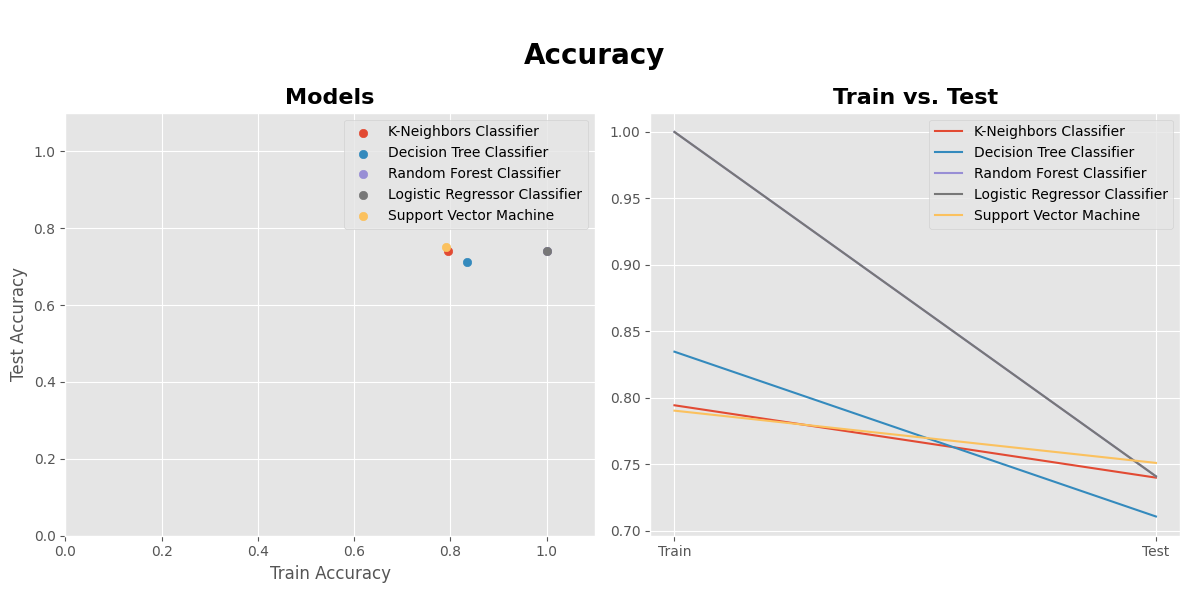

In [51]:
# Graficos: Accuracy
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle('\nAccuracy', fontsize=20, weight='bold')

# Scatter Plot
axs[0].set_xlim(0, 1.1); axs[0].set_ylim(0, 1.1)
axs[0].set_xlabel('Train Accuracy'); axs[0].set_ylabel('Test Accuracy')
axs[0].set_title('Models', fontsize=16, weight='bold')

for name, model in accuracy.items():
    x = model['Train']
    y = model['Test']
    axs[0].scatter(x, y, label=name)
axs[0].legend()

# Lineplot
axs[1].set_title('Train vs. Test', fontsize=16, weight='bold')

for name, model in accuracy.items():
    axs[1].plot(model.keys(), model.values(), label=name)
axs[1].legend()

# General
plt.tight_layout(); plt.show()

In [52]:
file_name = 'best_model.pkl'
pickle.dump(models[best_model_name], open(file_name, 'wb'))